In [1]:
import sys

%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import distributions as D

Parameter Settings
-------------------


In [2]:
num_epochs = 100
batch_size = 128
learning_rate = 1e-3
use_gpu = True

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We do not center them at 0, because we will be using a binary cross-entropy loss that treats pixel values as probabilities in [0,1]. We create both a training set and a test set.

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
class HVAE(nn.Module):
  def __init__(self, device):
    super(HVAE, self).__init__()

    self.device = device
    self.c = 64
    self.z_dims = 32
    self.mu_dims = 4

    # Layers for q(z|x):
    self.qz_conv1 = nn.Conv2d(in_channels=1, out_channels=self.c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
    self.qz_conv2 = nn.Conv2d(in_channels=self.c, out_channels=self.c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
    self.qz_mu = nn.Linear(in_features=self.c*2*7*7, out_features=self.z_dims)
    self.qz_logvar = nn.Linear(in_features=self.c*2*7*7, out_features=self.z_dims)

    # Layers for q(mu|z):
    h_dims = self.z_dims // 2
    self.qmu_l1 = nn.Linear(in_features=self.z_dims, out_features=h_dims)
    # self.qmu_l2 = nn.Linear(in_features=h_dims, out_features=(h_dims//2))
    # h_dims = h_dims // 2
    self.qmu_mu = nn.Linear(in_features=h_dims, out_features=self.mu_dims)
    self.qmu_logvar = nn.Linear(in_features=h_dims, out_features=self.mu_dims)

    # Layers for p(z|mu):
    h_dims = self.mu_dims * 2
    self.pz_l1 = nn.Linear(in_features=self.mu_dims, out_features=h_dims)
    # self.pz_l2 = nn.Linear(in_features=h_dims, out_features=(h_dims*2))
    # h_dims = h_dims * 2
    self.pz_mu = nn.Linear(in_features=h_dims, out_features=self.z_dims)
    self.pz_logvar = nn.Linear(in_features=h_dims, out_features=self.z_dims)

    # Layers for p(x|z):
    self.px_l1 = nn.Linear(in_features=self.z_dims, out_features=self.c*2*7*7)
    self.px_conv1 = nn.ConvTranspose2d(in_channels=self.c*2, out_channels=self.c, kernel_size=4, stride=2, padding=1)
    self.px_conv2 = nn.ConvTranspose2d(in_channels=self.c, out_channels=1, kernel_size=4, stride=2, padding=1)

  def q_z(self, x):
    h = F.relu(self.qz_conv1(x))
    h = F.relu(self.qz_conv2(h))
    h = h.view(h.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
    z_mu = self.qz_mu(h)
    z_logvar = self.qz_logvar(h)
    return self.reparameterize(z_mu, z_logvar), z_mu, z_logvar

  def q_mu(self, z):
    h = F.relu(self.qmu_l1(z))
    # h = F.relu(self.qmu_l2(h))
    mu_mu = self.qmu_mu(h)
    mu_logvar = self.qmu_logvar(h)
    return self.reparameterize(mu_mu, mu_logvar), mu_mu, mu_logvar

  def p_z(self, mu):
    h = F.relu(self.pz_l1(mu))
    # h = F.relu(self.pz_l2(h))
    z_mu = self.pz_mu(h)
    z_logvar = self.pz_logvar(h)
    return self.reparameterize(z_mu, z_logvar), z_mu, z_logvar

  def p_x(self, z):
    h = self.px_l1(z)
    h = h.view(h.size(0), self.c*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
    h = F.relu(self.px_conv1(h))
    x = torch.sigmoid(self.px_conv2(h)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
    return x

  def reparameterize(self, mu, logvar):
    eps = Variable(torch.randn(mu.size()))
    eps = eps.to(self.device)

    std = torch.exp(0.5 * logvar)
    return mu + eps * std

  def sample_x(self, num=10):
    # sample latent vectors from the normal distribution
    mu = torch.randn(num, self.mu_dims)
    mu = mu.to(self.device)

    z_hat, _, _ = self.p_z(mu)
    x_prob = self.p_x(z_hat)

    return x_prob

  def reconstruction(self, x):
    z, _, _ = self.q_z(x)
    mu, _, _ = self.q_mu(z)
    z_hat, _, _ = self.p_z(mu)
    x_prob = self.p_x(z_hat)

    return x_prob

  def forward(self, x):
    z, qz_mu, qz_logvar = self.q_z(x)
    mu, qmu_mu, qmu_logvar = self.q_mu(z)

    z_hat, pz_mu, pz_logvar = self.p_z(mu)
    x_prob = self.p_x(z_hat)

    # For likelihood : <log p(x|z)>_q :
    elbo = torch.sum(torch.flatten(x.view(-1, 784) * torch.log(x_prob.view(-1, 784) + 1e-8)
                                    + (1 - x.view(-1, 784)) * torch.log(1 - x_prob.view(-1, 784) + 1e-8),
                                    start_dim=1),
                      dim=-1)
    
    qmu = D.normal.Normal(qmu_mu, torch.exp(0.5 * qmu_logvar))
    qmu = D.independent.Independent(qmu, 1)
    qz = D.normal.Normal(qz_mu, torch.exp(0.5 * qz_logvar))
    qz = D.independent.Independent(qz, 1)
    pz = D.normal.Normal(pz_mu, torch.exp(0.5 * pz_logvar))
    pz = D.independent.Independent(pz, 1)
    pmu = D.normal.Normal(torch.zeros_like(mu), torch.ones_like(mu))
    pmu = D.independent.Independent(pmu, 1)
    # For : <log p(z|u)>_q
    elbo += pz.log_prob(z)

    # For : <log p(mu)>_q
    elbo += pmu.log_prob(mu)

    # For : -<log q(mu|z)>_q
    elbo -= qmu.log_prob(mu)

    # For : -<log q(z|x)>_q
    elbo -= qz.log_prob(z)

    return -elbo.mean()



In [5]:
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
print(device)
hvae = HVAE(device)
hvae = hvae.to(device)

cuda:0


In [6]:
optimizer = torch.optim.Adam(params=hvae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
hvae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        optimizer.zero_grad()
        
        image_batch = image_batch.to(device)

        loss = hvae(image_batch)
        
        # backpropagation
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 100] average reconstruction error: 207.890512
Epoch [2 / 100] average reconstruction error: 184.520461
Epoch [3 / 100] average reconstruction error: 171.670454
Epoch [4 / 100] average reconstruction error: 166.560416
Epoch [5 / 100] average reconstruction error: 163.423138
Epoch [6 / 100] average reconstruction error: 156.846506
Epoch [7 / 100] average reconstruction error: 151.195648
Epoch [8 / 100] average reconstruction error: 148.896041
Epoch [9 / 100] average reconstruction error: 147.367744
Epoch [10 / 100] average reconstruction error: 146.271481
Epoch [11 / 100] average reconstruction error: 145.390859
Epoch [12 / 100] average reconstruction error: 144.742544
Epoch [13 / 100] average reconstruction error: 144.309377
Epoch [14 / 100] average reconstruction error: 143.874977
Epoch [15 / 100] average reconstruction error: 143.423798
Epoch [16 / 100] average reconstruction error: 143.088352
Epoch [17 / 100] average reconstruction error: 142.747392
Epoch [18 

In [7]:
# this is how the VAE parameters can be saved:
# torch.save(hvae.state_dict(), './pretrained/hvae.pth')

Original images


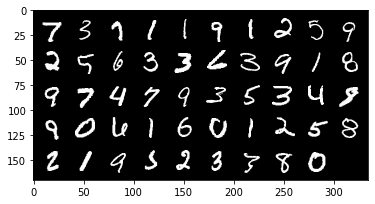

VAE reconstruction:


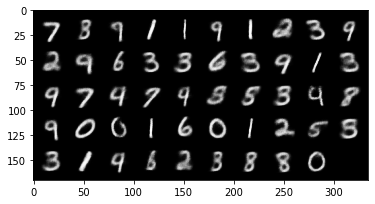

In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

hvae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images = hvae.reconstruction(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, hvae)

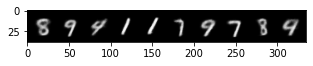

In [9]:
hvae.eval()

with torch.no_grad():

    # sample images
    img_samples = hvae.sample_x()
    img_samples = img_samples.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_samples,10,5))
    plt.show()